Классификация рентгеновских изображений грудной клетки (Пневмония, ковид)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Conv2DTranspose, concatenate

20% процентов выборки приходится на тестовый набор

In [3]:
train_dir = "Data/train/"
test_dir = "Data/test/"
print("Train:")
print(f"COVID = {len(os.listdir(os.path.join(train_dir, 'COVID19')))}")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(train_dir, 'NORMAL')))}")

print("\nTest:")
print(f"COVID = {len(os.listdir(os.path.join(test_dir, 'COVID19')))}")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

Train:
COVID = 460
PNEUMONIA = 3418
NORMAL = 1266

Test:
COVID = 116
PNEUMONIA = 855
NORMAL = 317


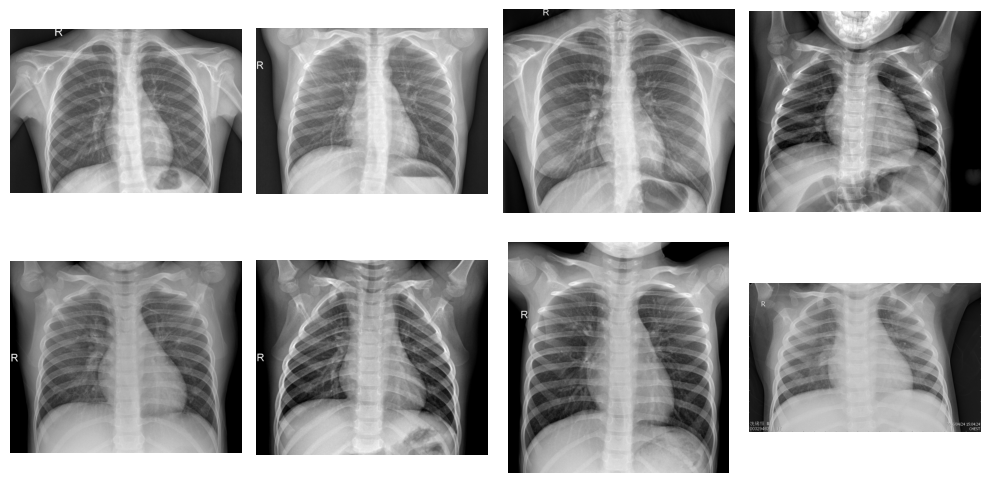

In [4]:
normal = os.listdir("Data/train/NORMAL")
normal_dir = "Data/train/NORMAL"
plt.figure(figsize=(10, 10))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()

In [5]:
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
)

In [6]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=32,
                                            shuffle=True,
                                            classes = ["NORMAL", "COVID19","PNEUMONIA"],
                                            class_mode='categorical',
                                            target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir,
                                           batch_size=1,
                                           shuffle=False,
                                           classes = ["NORMAL", "COVID19","PNEUMONIA"],
                                           class_mode='categorical',
                                           target_size=(320, 320))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


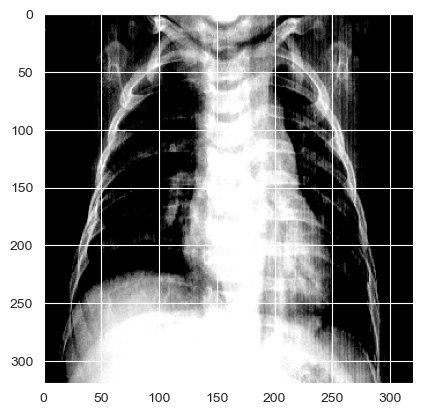

In [7]:
generated_image, label = train.__getitem__(1)
plt.imshow(generated_image[5])

Модель сверточной нейронной сети #1
1) 32 батча
2) Вход (320, 320, 3)

In [8]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))

model.add(Dense(128, activation='relu'))

model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 318, 318, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 316, 316, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 316, 316, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 158, 158, 32)     0         
 )                                                               
                                                        

In [10]:
ml1 = model.fit(train,epochs=40)

Epoch 1/40
161/161 [==============================] - 131s 773ms/step - loss: 2.1187 - accuracy: 0.8668
Epoch 2/40
161/161 [==============================] - 94s 581ms/step - loss: 0.4047 - accuracy: 0.9114
Epoch 3/40
161/161 [==============================] - 86s 531ms/step - loss: 0.2573 - accuracy: 0.9279
Epoch 4/40
161/161 [==============================] - 85s 530ms/step - loss: 0.2801 - accuracy: 0.9257
Epoch 5/40
161/161 [==============================] - 86s 531ms/step - loss: 0.1918 - accuracy: 0.9397
Epoch 6/40
161/161 [==============================] - 87s 542ms/step - loss: 0.2115 - accuracy: 0.9378
Epoch 7/40
161/161 [==============================] - 88s 546ms/step - loss: 0.1498 - accuracy: 0.9531
Epoch 8/40
161/161 [==============================] - 87s 542ms/step - loss: 0.1317 - accuracy: 0.9578
Epoch 9/40
161/161 [==============================] - 89s 554ms/step - loss: 0.1367 - accuracy: 0.9570
Epoch 10/40
161/161 [==============================] - 88s 544ms/step - 

In [9]:
#model.save('ML1_1')
#model = keras.models.load_model('ML1')

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

classes = ["NORMAL", "COVID19", "PNEUMONIA"]
y_pred = model.predict(test)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=test.classes
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

1288/1288 [==============================] - 28s 21ms/step


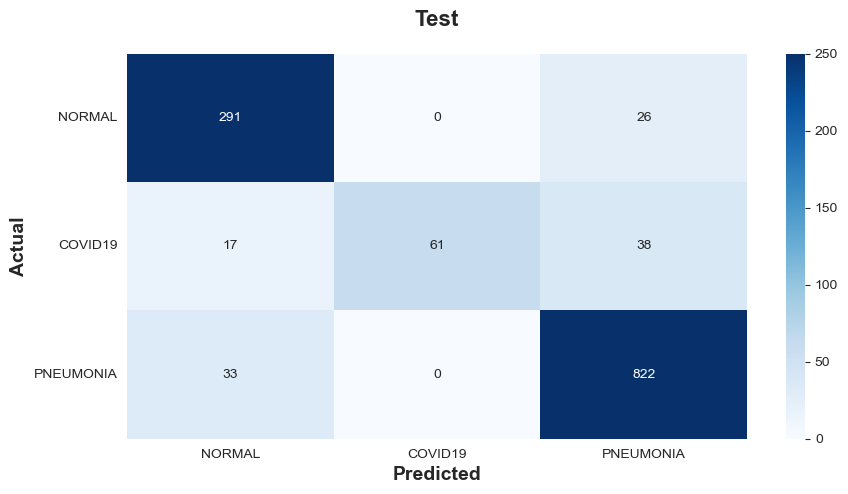

In [12]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Test',fontsize = 16,weight = 'bold',pad=20);

In [13]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       317
           1       1.00      0.53      0.69       116
           2       0.93      0.96      0.94       855

    accuracy                           0.91      1288
   macro avg       0.93      0.80      0.84      1288
weighted avg       0.92      0.91      0.91      1288



Text(0.5, 1.0, 'Accuracy Evolution')

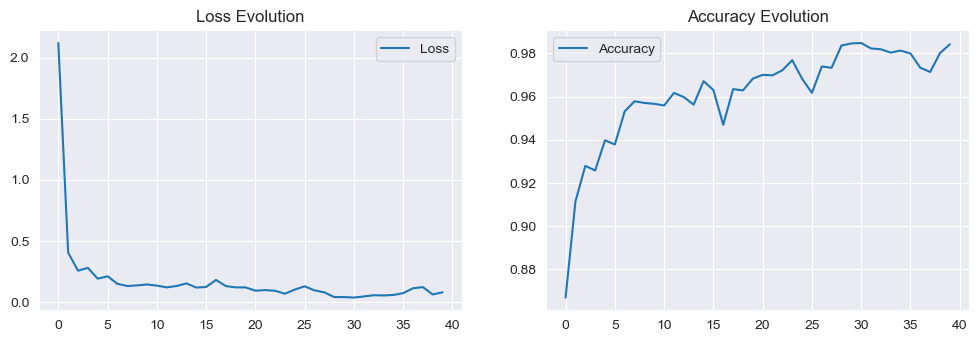

In [14]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(ml1.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(ml1.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

Модель сверточной нейронной сети #2
1) 24 батча
2) Вход (240, 240, 3)

In [24]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=24,
                                            shuffle=True,
                                            classes = ["NORMAL", "COVID19","PNEUMONIA"],
                                            class_mode='categorical',
                                            target_size=(240, 240))

test = image_generator.flow_from_directory(test_dir,
                                           batch_size=1,
                                           shuffle=False,
                                           classes = ["NORMAL", "COVID19","PNEUMONIA"],
                                           class_mode='categorical',
                                           target_size=(240, 240))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [25]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation = "relu", input_shape = (240,240,3), padding='same', kernel_initializer="he_normal"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation = "relu",padding='same', kernel_initializer="he_normal"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation = "relu", padding='same', kernel_initializer="he_normal"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(filters=512,kernel_size=(3,3), activation = "relu", padding='same', kernel_initializer="he_normal"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.1))

model.add(Dense(3, activation = "softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 240, 240, 64)      1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 120, 120, 64)     0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 120, 120, 64)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 128)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 60, 60, 128)      

In [27]:
ml2 = model.fit(train,epochs=40)

Epoch 1/40
215/215 [==============================] - 317s 1s/step - loss: 17.6387 - accuracy: 0.8408
Epoch 2/40
215/215 [==============================] - 306s 1s/step - loss: 0.2417 - accuracy: 0.9141
Epoch 3/40
215/215 [==============================] - 306s 1s/step - loss: 0.2183 - accuracy: 0.9220
Epoch 4/40
215/215 [==============================] - 302s 1s/step - loss: 0.1889 - accuracy: 0.9314
Epoch 5/40
215/215 [==============================] - 306s 1s/step - loss: 0.1711 - accuracy: 0.9368
Epoch 6/40
215/215 [==============================] - 307s 1s/step - loss: 0.1654 - accuracy: 0.9390
Epoch 7/40
215/215 [==============================] - 304s 1s/step - loss: 0.1620 - accuracy: 0.9432
Epoch 8/40
215/215 [==============================] - 307s 1s/step - loss: 0.1402 - accuracy: 0.9475
Epoch 9/40
215/215 [==============================] - 308s 1s/step - loss: 0.1233 - accuracy: 0.9545
Epoch 10/40
215/215 [==============================] - 305s 1s/step - loss: 0.1097 - accur

In [28]:
#model.save('ML1_2')
#ml2 = keras.models.load_model('ML1_2')

INFO:tensorflow:Assets written to: ML1_2\assets


INFO:tensorflow:Assets written to: ML1_2\assets


In [29]:
from sklearn.metrics import confusion_matrix, classification_report

classes = ["NORMAL", "COVID19", "PNEUMONIA"]
y_pred = model.predict(test)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=test.classes
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

1288/1288 [==============================] - 43s 34ms/step


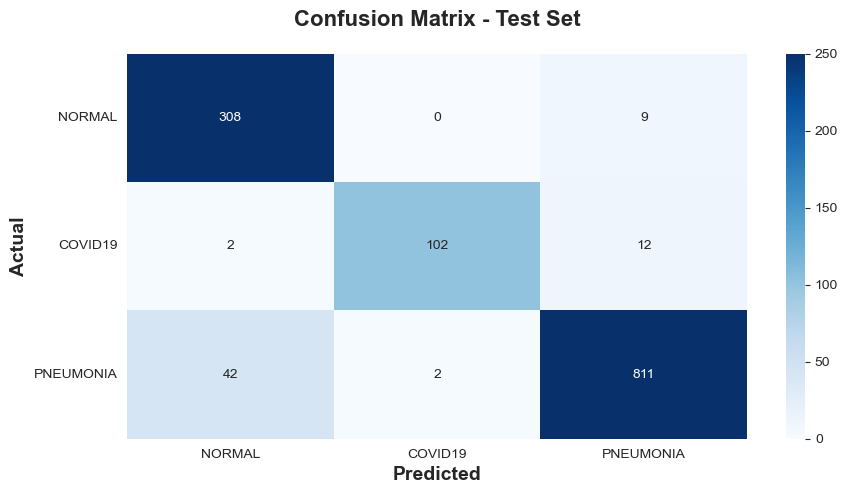

In [30]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [31]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       317
           1       0.98      0.88      0.93       116
           2       0.97      0.95      0.96       855

    accuracy                           0.95      1288
   macro avg       0.94      0.93      0.94      1288
weighted avg       0.95      0.95      0.95      1288



Text(0.5, 1.0, 'Accuracy Evolution')

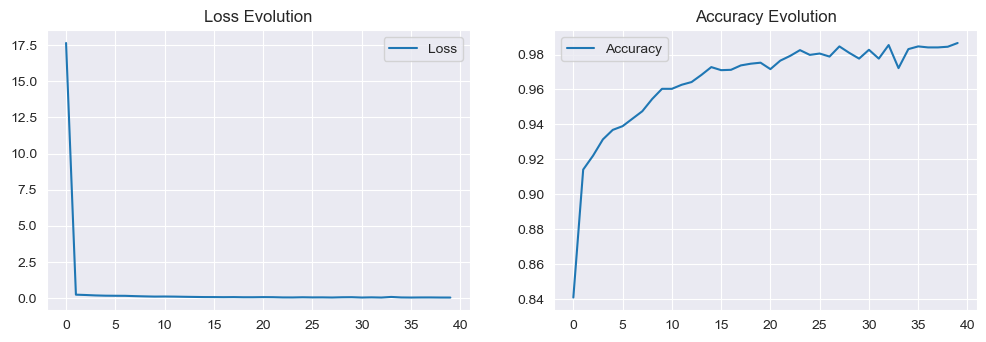

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(ml2.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(ml2.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

Модель №3 U-net
1) 25 батчей
2) Вход (256, 256, 3)
3) Классы сбалансированы введением весовых коэффициентов
4) Используется валидационная выборка, 10% от обучающей

In [56]:
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=25,
                                            shuffle=True,
                                            classes = ["NORMAL", "COVID19","PNEUMONIA"],
                                            class_mode='categorical',
                                            target_size=(256, 256))

test = image_generator.flow_from_directory(test_dir,
                                           batch_size=1,
                                           shuffle=False,
                                           classes = ["NORMAL", "COVID19","PNEUMONIA"],
                                           class_mode='categorical',
                                           target_size=(256, 256))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [59]:
#from tensorflow.keras import layers
# Encoder
inputs = keras.Input((256,256,3))
conv1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same',kernel_initializer="he_normal")(inputs)
conv1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv1)
drop1 = keras.layers.Dropout(0.2)(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

conv2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer="he_normal")(pool1)
conv2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv2)
drop2 = keras.layers.Dropout(0.2)(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop2)

conv3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same',kernel_initializer="he_normal")(pool2)
conv3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv3)
drop3 = keras.layers.Dropout(0.2)(conv3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3)

conv4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same',kernel_initializer="he_normal")(pool3)
conv4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv4)
drop4 = keras.layers.Dropout(0.3)(conv4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

# Decoder
conv5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same',kernel_initializer="he_normal")(pool4)
conv5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv5)
drop5 = keras.layers.Dropout(0.5)(conv5)

up6 = keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same',kernel_initializer="he_normal")(drop5)
merge6 = keras.layers.concatenate([drop4, up6], axis=3)
conv6 = keras.layers.Conv2D(256, 3, activation='relu', padding='same',kernel_initializer="he_normal")(merge6)
conv6 = keras.layers.Conv2D(256, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv6)

up7 = keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same',kernel_initializer="he_normal")(conv6)
merge7 = keras.layers.concatenate([conv3, up7], axis=3)
conv7 = keras.layers.Conv2D(128, 3, activation='relu', padding='same',kernel_initializer="he_normal")(merge7)
conv7 = keras.layers.Conv2D(128, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv7)

up8 = keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same',kernel_initializer="he_normal")(conv7)
merge8 = keras.layers.concatenate([conv2, up8], axis=3)
conv8 = keras.layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer="he_normal")(merge8)
conv8 = keras.layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv8)

up9 = keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same',kernel_initializer="he_normal")(conv8)
merge9 = keras.layers.concatenate([conv1, up9], axis=3)
conv9 = keras.layers.Conv2D(32, 3, activation='relu', padding='same',kernel_initializer="he_normal")(merge9)
conv9 = keras.layers.Conv2D(32, 3, activation='relu', padding='same',kernel_initializer="he_normal")(conv9)


lay10 = keras.layers.Flatten()(conv9)
lay10 = keras.layers.Dense(128, activation = "relu")(lay10)
drop10 = keras.layers.Dropout(0.3)(lay10)

lay11 = keras.layers.Dense(3, activation = "softmax")(drop10)

model = keras.Model(inputs=inputs, outputs=lay11)

In [60]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_186 (Conv2D)            (None, 256, 256, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_187 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_186[0][0]']             
                                )                                                          

In [61]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                                 ,np.unique(train)
                                                 ,train)

ml3 = model.fit(train,class_weight=class_weight,validation_split=0.1,epochs=15)

Epoch 1/15
206/206 [==============================] - 1303s 6s/step - loss: 22.3285 - accuracy: 0.8556 - val_loss: 0.1721 - val_accuracy: 0.9394
Epoch 2/15
206/206 [==============================] - 1280s 6s/step - loss: 0.1763 - accuracy: 0.9411 - val_loss: 0.2212 - val_accuracy: 0.9247
Epoch 3/15
206/206 [==============================] - 1227s 6s/step - loss: 0.0884 - accuracy: 0.9706 - val_loss: 0.1570 - val_accuracy: 0.9449
Epoch 4/15
206/206 [==============================] - 1222s 6s/step - loss: 0.0459 - accuracy: 0.9862 - val_loss: 0.1648 - val_accuracy: 0.9433
Epoch 5/15
206/206 [==============================] - 1222s 6s/step - loss: 0.0279 - accuracy: 0.9924 - val_loss: 0.2280 - val_accuracy: 0.9301
Epoch 6/15
206/206 [==============================] - 1221s 6s/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.2985 - val_accuracy: 0.9309
Epoch 7/15
206/206 [==============================] - 1225s 6s/step - loss: 0.0163 - accuracy: 0.9955 - val_loss: 0.1741 - val_accuracy

In [67]:
#model.save('ML2_2')
#ml3 = keras.models.load_model('ML2_1')

INFO:tensorflow:Assets written to: ML2_2\assets


INFO:tensorflow:Assets written to: ML2_2\assets


In [63]:
from sklearn.metrics import confusion_matrix, classification_report

classes = ["NORMAL", "COVID19", "PNEUMONIA"]
y_pred = model.predict(test)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true=test.classes
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

1288/1288 [==============================] - 124s 96ms/step


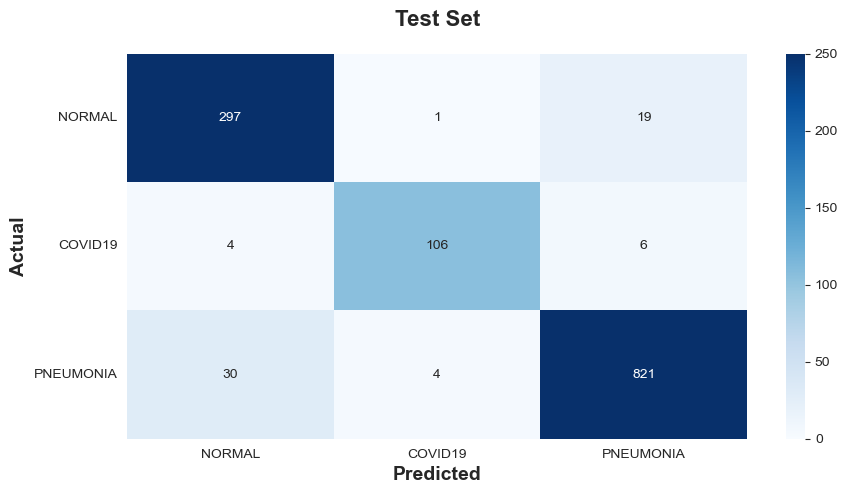

In [66]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Test Set',fontsize = 16,weight = 'bold',pad=20);

In [65]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       317
           1       0.95      0.91      0.93       116
           2       0.97      0.96      0.97       855

    accuracy                           0.95      1288
   macro avg       0.94      0.94      0.94      1288
weighted avg       0.95      0.95      0.95      1288



Text(0.5, 1.0, 'Accuracy Evolution')

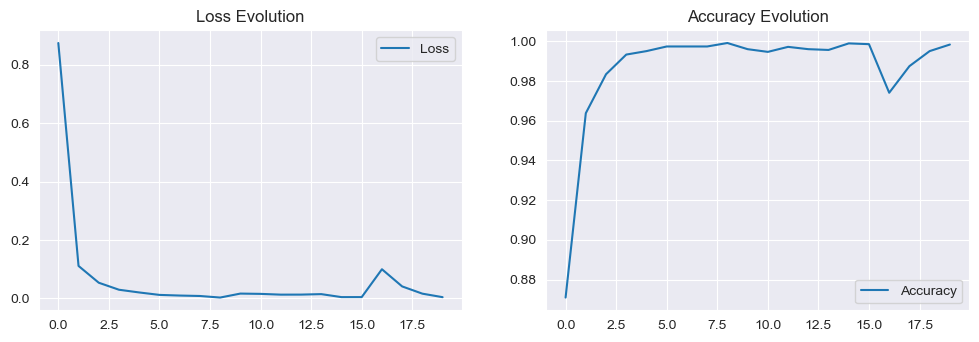

In [45]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(ml3.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(ml3.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')